# PAGE RANK
## Data set description
![](https://i.imgur.com/Hs22V7n.png)

* Nodes represent people (email accounts).
* Edges represent emails $ \forall \space \space (u,v) \in E $ it means that there
exists at least an email sent from $u$ to $v$.

## Page rank interpretation

The one with the highest probability in the stationary distribution is the person with the
hugest reach to people.

## Exit criteria

Because according to the fact that the distribution converges to the stationary distribution
given that the graph is irreducible and aperiodic. We will investigate these
and since the graph is reducible because there are multiple SCCs not one (see the statistics above).
I will extract this SCC and run the algorithm on it.

Now the exit criteria is having $p \pi = p $ since we are working with real numbers here.

if $ v = p - \pi p \rightarrow  v^{T} v < \epsilon | \epsilon = 10^{-3} $

# Reading the dataset
Source of data: [email-Eu-core network](https://snap.stanford.edu/data/email-Eu-core.html "Stanford Large Network Dataset Collection")
it is unzipped in ```./data``` folder into ```email-Eu-core.txt``` representing the edges and ```email-Eu-core-department-labels.txt```
mapping the nodes to departments.

In [1]:
import numpy as np
def read_it(filed,  *functions):
    data = filed.readlines()
    nodes, depts  = [], []
    for line in data:
        a,b = iter(line.split(' '))
        b = b.replace('\n','')
        a,b = map(int, [a,b])
        nodes.append(a)
        depts.append(b)
    return nodes, depts



node_label_folder = open('./data/email-Eu-core-department-labels.txt')
nodes, depts = read_it(node_label_folder)

node_dept = dict()
for node, dept in zip(nodes, depts):
    try:
        node_dept[dept].append(node)
    except:
        node_dept[dept]=[node]

nodes = np.unique(nodes)
depts = np.unique(depts)
del node_label_folder
del node
del dept

reading edges

In [2]:
edges_folder = open('./data/email-Eu-core.txt')
inn, out = read_it(edges_folder)
adj = [[] for node in nodes]
for a,b in zip(inn,out):
    adj[a].append(b)
del edges_folder
del inn
del out
del a
del b


# Sizes of departments

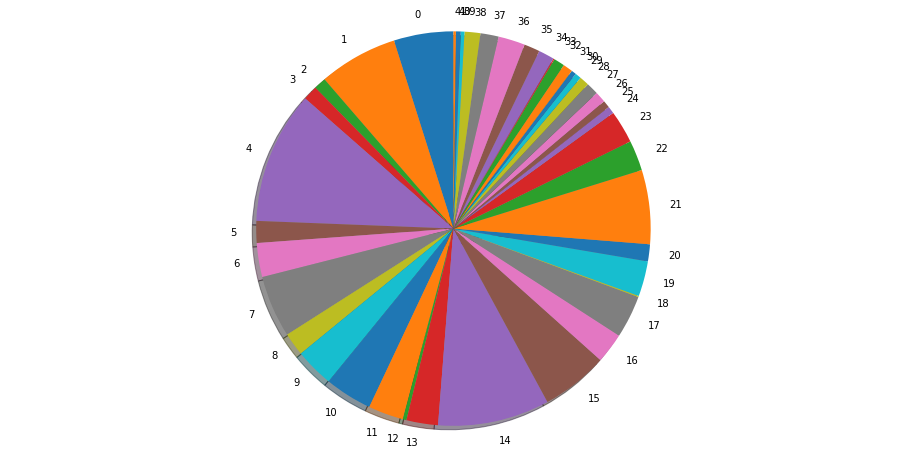

In [3]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = depts
sizes = list(map(len,map(lambda x:node_dept[x],depts)))
plt.rcParams['figure.figsize'] = (16,8)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



# Get the largest SCC to perform analysis

implementation of Tarjan algorithm

In [4]:
cnt = 1
SCCs = []
def dfs(x, cnt, low_link, index, on_stack, S, in_SCC):
    index[x] = cnt
    low_link[x] = cnt
    cnt+=1
    S.append(x)
    on_stack[x] = True
    for u in adj[x]:
        if index[u] == 0:
            dfs(u,cnt, low_link, index, on_stack, S, in_SCC)
            low_link[x] = min(low_link[x], low_link[u])
        elif on_stack[u]:
            low_link[x] = min(low_link[x], low_link[u])

    if in_SCC[x]:
        return
    in_SCC[x] = True
    if low_link[x] == index[x]:
        SCCs.append([])
        while S[-1] != x:
            w = S[-1]
            in_SCC[w] = True
            on_stack[w] = False
            SCCs[-1].append(w)
            S.pop()
        S.pop()
        SCCs[-1].append(x)
    return

def get_list(N, initial=0):
    return [initial for i in range(N)]

N = len(nodes)
low_link = get_list(N)
index = get_list(N)
S = get_list(N)
on_stack = get_list(N, False)
in_SCC = get_list(N, False)
for node in nodes:
    if index[node] != 0:
        continue
    cnt = 1
    dfs(node,cnt, low_link, index, on_stack, S, in_SCC)
print('Number of SCCs: ', len(SCCs))


Number of SCCs:  203


Now lets see the sizes of these SCCs

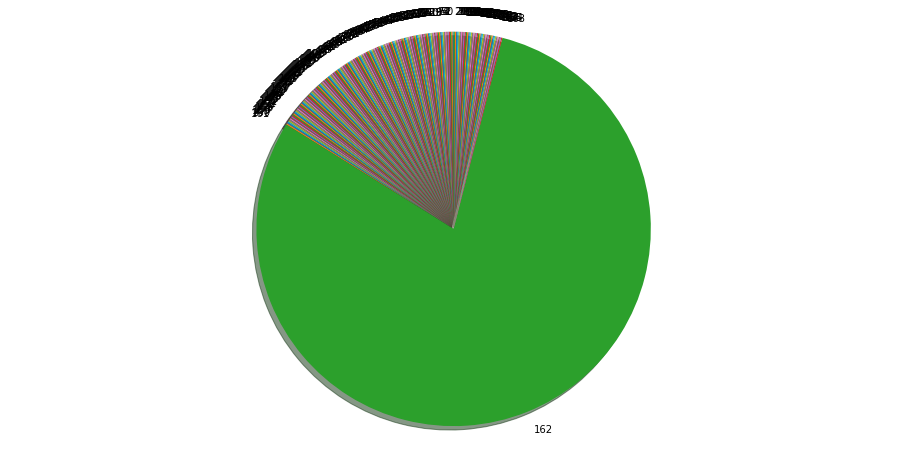

In [5]:
import matplotlib.pyplot as plt

labels = [i for i in range(len(SCCs))]
sizes = list(map(len,SCCs))
plt.rcParams['figure.figsize'] = (16,8)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We can say that ```162``` is dominant we will discard all other nodes in other SCCs and edges
related to these nodes

In [6]:
def modify_adj(adj, nodes):
    new_adj = dict()
    for node in nodes:
        new_adj[node] = []
        for b in adj[node]:
            if b in nodes:
                new_adj[node].append(b)
    return new_adj

nodes = SCCs[162]
adj = modify_adj(adj, nodes)
print(len(nodes))

803


We have 803 nodes in the SCC we can deduct that the majority of nodes lie in one componened

# Lets page rank

now we will create the probability matrix
$ \forall \space (u,v) \in E \space : p(u,v) = \frac{1}{outdeg(u)} $ where
$outdeg$ is the out degree of vertex $u$.


In [7]:
import numpy as np
N = len(nodes)
probs = np.zeros((N, N))
hashy = dict()
inverse_hashy = dict()
for cnt, node in zip(list(range(N)), nodes):
    hashy[node] = cnt
    inverse_hashy[cnt] = node
for cur in nodes:
    for nxt in adj[cur]:
        a = hashy[cur]
        b = hashy[nxt]
        probs[a][b] = 1.0/len(adj[cur])

print(np.mean(probs))

0.0012453300124533003


most of the values in the prob matrix are zeros

now lets run a random initial state to see how it converges




160 has the most number of edges 325 edge so lets track its probability

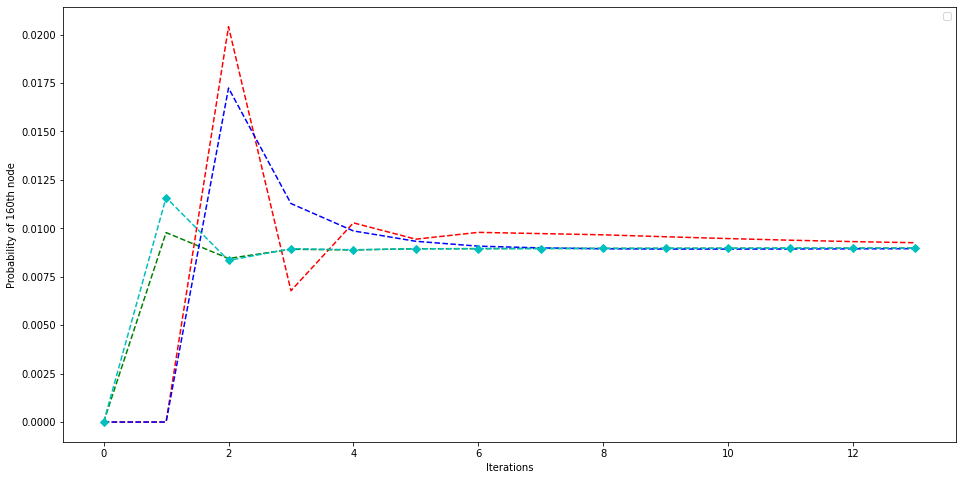

In [32]:
iterations = 14
randomlines = 4
lines = np.zeros((randomlines,iterations))
p = np.random.rand(randomlines,len(nodes))
p[0] = np.zeros(len(nodes))
p[2] = np.zeros(len(nodes))
p[0][0]=1
p[2][33] = 1
for i in range(randomlines):
    p[i] = p[i] / sum(p[i])

for i in range(1,iterations):
    for j in range(randomlines):
        p[j] = p[j].dot(probs)
        lines[j][i] = p[j][hashy[160]]
        
plt.rcParams['figure.figsize'] = (16, 8)
plt.xlabel('Iterations')
plt.ylabel('Probability of 160th node')
plt.legend('Red, Blue ,Green are lines from different initial points and converge to a value')
cols = ['--r','--g','--b','--Dc']
for i in range(randomlines):
    plt.plot(list(range(iterations)), lines[i], cols[i])
plt.show()

# Exit criteria implemented

In [39]:
iterations = 14

p = np.random.rand(len(nodes))
p = p / sum(p)
lp = p
eps = 1e-3
for i in range(1,iterations):
    p = p.dot(probs)
    teps = (p - lp).dot(p - lp)
    if teps < eps:
        print(f'Reached exit criteria {teps} < {eps} at iteration {i} !!')
        break
    lp = p

prob_nod = list(zip(p, map(lambda x: inverse_hashy[x], list(range(len(nodes))))))
prob_nod = list(reversed(sorted(prob_nod)))
print(prob_nod[:10])

Reached exit criteria 0.00016298527152882515 < 0.001 at iteration 2 !!
[(0.008749124543386062, 160), (0.006801199709725213, 62), (0.006754882726348646, 86), (0.006728716863279834, 107), (0.0062006289490241255, 5), (0.006099294936229391, 121), (0.006065110266008496, 129), (0.005816113882863929, 64), (0.005552591410598657, 434), (0.005512117527393561, 183)]


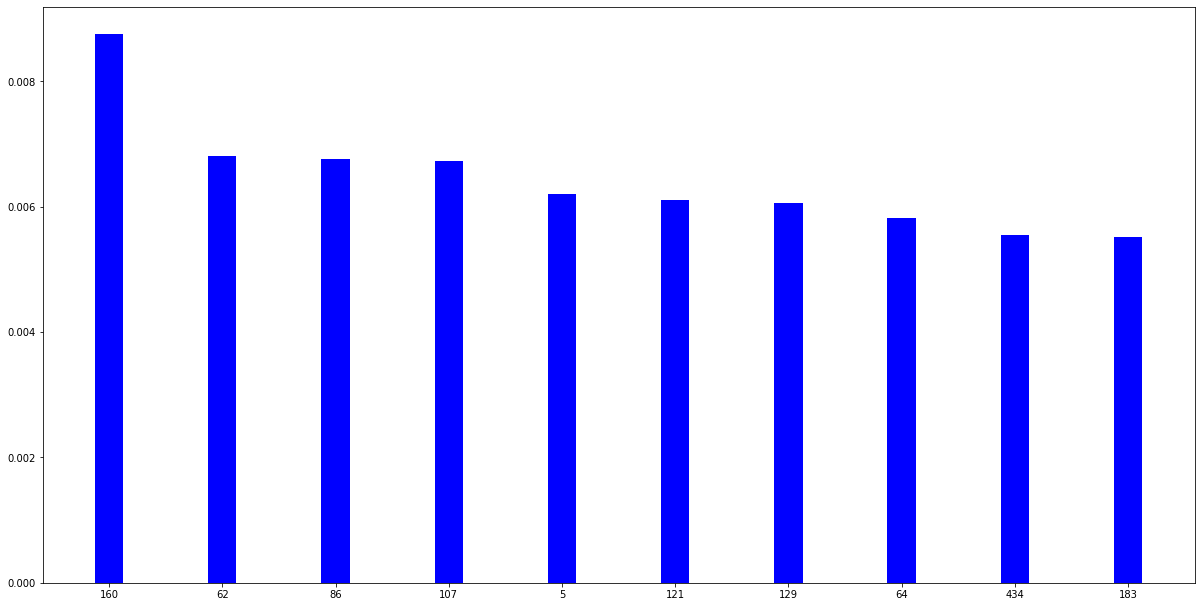

In [48]:
import numpy as np
import matplotlib.pyplot as plt

x = list(map(lambda x: x[0], prob_nod[:10]))
y = list(map(lambda x: x[1], prob_nod[:10]))
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#for i in range(len(x)):
ax.bar(list(map(str, y)), x, color = 'b', width = 0.25)


plt.show()

# 160 is the most reached 
Meaning that 160 approximately has the best connection graph that her
contacts and their contacts span the most

# Notes to keep in mind
![](https://i.imgur.com/gFoOW5z.png)

Takeaways
The main takeaways of this article are the following:
* Random processes are collections of random variables, often indexed over time (indices often represent discrete or continuous time).

* for a random process, the Markov property says that, given the present, the probability of the future is independent of the past (this property is also called “memoryless property”)

* discrete time Markov chain are random processes with discrete time indices and that verify the Markov property

* the Markov property of Markov chains makes the study of these processes much more tractable and allows to derive some interesting explicit results (mean recurrence time, stationary distribution…)
* one possible interpretation of the PageRank (not the only one) consists in imagining a web surfer that randomly navigates from page to page and in taking the induced stationary distribution over pages as a factor of ranking (roughly, the most visited pages in steady-state must be the one linked by other very visited pages and then must be the most relevant)

To conclude, let’s emphasise once more how powerful Markov chains are for problems modelling when dealing with random dynamics. Due to their good properties, they are used in various fields such as queueing theory (optimising the performance of telecommunications networks, where messages must often compete for limited resources and are queued when all ressources are already allocated), statistics (the well known “Markov Chain Monte Carlo” random variables generation technique is based on Markov chains), biology (modelling of biological populations evolution), computer science (hidden Markov models are important tools in information theory and speech recognition) and others.

Obviously, the huge possibilities offered by Markov chains in terms of modelling as well as in terms of computation go far behind what have been presented in this modest introduction and, so, we encourage the interested reader to read more about these tools that entirely have there place in the (data) scientist toolbox.

Thanks for reading!

